# YouTube Views with XGBoost
> Predicting views using XGBoost and data from YouTube and Google APIs 
- toc: true
- badges: true
- comments: true
- categories: [XGBoost,YouTube,API,Google Vision]
- image: images/youtube.jpg
---


![kaggle_img000](https://github.com/jmmerrell/ws/blob/master/images/youtube.jpg?raw=true)

I wanted to find the features that help me get more views on YouTube. Successfully identified which YouTube videos are successful with 85% accuracy. I used the YouTube API to gather data from my competitors on YouTube. I also used Google Vision's deep learning models to analyzye thumbnail images, and add that data to the YouTube API data. Data from nearly 2,000 videos was used to train and test an XGBoost model.  

## 1. Objective

We want to classify videos as succesful(high views per subscriber) or unsuccessful by scraping data from YouTube and using the data to train an XGBoost model. The main sources of data for this project are the APIs for YouTube and GoogleVision. From these two sources we gather information about each of my competitor's YouTube channels: views, subscribers, number of videos, titles of the videos, duration of each video, etc. From the YouTube API I also extract the thubnail URL for each video. Later I explain how the Google Vision API analyzes the image of the thumbnail for facial and text recognition. I combine the youtube data and the thumbnail data together for the analysis. 

## 2. Import the necessary libraries and data set

### 2.1. Libraries

The libraries used in this project are the following.

In [1]:
import os
os.chdir("C:\\Users\\merre\\Desktop\\envs\\yt_api_env\\Lib\\site-packages")
from numpy.core.fromnumeric import shape
from numpy.lib.function_base import diff
import pandas as pd
import re
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from pandas.core.indexes.base import Index
import emoji
from scipy import stats
import fasttext
from collections import Counter
from pprint import pprint 
from IPython.display import display_html
from itertools import chain,cycle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
import shap
import xgboost as xgb
import matplotlib.pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
import altair as alt
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 2.2. Data Sets

I merge together all the datasets taken from YouTube's API with the Google Vision API thumbnail image data. You can see the full code below for retreiving this data. 

In [ ]:
YouTube API Data Pull

In [ ]:
#collapse-hide

import json
import requests
from numpy import random
from time import sleep
import os

class YTstats:

    def __init__(self, api_key, channel_id):
        self.api_key = api_key
        self.channel_id = channel_id
        self.channel_statistics = None
        self.video_data = None

    def extract_all(self):
        self.get_channel_statistics()
        self.get_channel_video_data()

    def get_channel_statistics(self):
        """Extract the channel statistics"""
        print('get channel statistics...')
        url = f'https://www.googleapis.com/youtube/v3/channels?part=statistics&id={self.channel_id}&key={self.api_key}'
        
        json_url = requests.get(url)
        data = json.loads(json_url.text)
        try:
            data = data['items'][0]['statistics']
        except KeyError:
            print('Could not get channel statistics')
            data = {}

        self.channel_statistics = data
        return data

    def get_channel_video_data(self):
        global s
        s = requests.Session()
        "Extract all video information of the channel"
        print('get video data...')
        channel_videos, channel_playlists = self._get_channel_content(limit=50)

        parts=["snippet", "statistics","contentDetails", "topicDetails"]
        print(len(channel_videos))
        ii = 0
       
        for video_id in channel_videos:
            ii += 1
            print(ii/len(channel_videos))
            for part in parts:
                data = self._get_single_video_data(video_id, part)
                channel_videos[video_id].update(data)


        self.video_data = channel_videos
        return channel_videos

    def _get_single_video_data(self, video_id, part):
        """
        Extract further information for a single video
        parts can be: 'snippet', 'statistics', 'contentDetails', 'topicDetails'
        """
        sleep(random.uniform(1, 3)/2)
        url = f"https://www.googleapis.com/youtube/v3/videos?part={part}&id={video_id}&key={self.api_key}"
        json_url = s.get(url)
        data = json.loads(json_url.text)
        print(url)
    
        try:
            data = data['items'][0][part]
        except KeyError as e:
            print(f'Error! Could not get {part} part of data: \n{data}')
            data = dict()
        return data

    def _get_channel_content(self, limit=None, check_all_pages=True):
        """
        Extract all videos and playlists, can check all available search pages
        channel_videos = videoId: title, publishedAt
        channel_playlists = playlistId: title, publishedAt
        return channel_videos, channel_playlists
        """
        url = f"https://www.googleapis.com/youtube/v3/search?key={self.api_key}&channelId={self.channel_id}&part=snippet,id&order=date"
        if limit is not None and isinstance(limit, int):
            url += "&maxResults=" + str(limit)

        vid, pl, npt = self._get_channel_content_per_page(url)
        idx = 0
        
        while(check_all_pages and npt is not None and idx < 50 and num_pages < 2):
            nexturl = url + "&pageToken=" + npt
            next_vid, next_pl, npt = self._get_channel_content_per_page(nexturl)
            vid.update(next_vid)
            pl.update(next_pl)
            idx += 1
            print(check_all_pages, idx, npt)

        return vid, pl

    def _get_channel_content_per_page(self, url):
        """
        Extract all videos and playlists per page
        return channel_videos, channel_playlists, nextPageToken
        """
        sleep(random.uniform(1, 3))
        json_url = requests.get(url)
        data = json.loads(json_url.text)
        channel_videos = dict()
        channel_playlists = dict()
        if 'items' not in data:
            print('Error! Could not get correct channel data!\n', data)
            return channel_videos, channel_playlists, None
        global num_pages
        num_pages+=1
        nextPageToken = data.get("nextPageToken", None)

        item_data = data['items']
        for item in item_data:
            try:
                kind = item['id']['kind']
                published_at = item['snippet']['publishedAt']
                title = item['snippet']['title']
                if kind == 'youtube#video':
                    video_id = item['id']['videoId']
                    channel_videos[video_id] = {'publishedAt': published_at, 'title': title}
                elif kind == 'youtube#playlist':
                    playlist_id = item['id']['playlistId']
                    channel_playlists[playlist_id] = {'publishedAt': published_at, 'title': title}
            except KeyError as e:
                print('Error! Could not extract data from item:\n', item)

        return channel_videos, channel_playlists, nextPageToken

    def dump(self):
        """Dumps channel statistics and video data in a single json file"""
        if self.channel_statistics is None or self.video_data is None:
            print('data is missing!\nCall get_channel_statistics() and get_channel_video_data() first!')
            return

        fused_data = {self.channel_id: {"channel_statistics": self.channel_statistics,
                              "video_data": self.video_data}}

        channel_title = self.video_data.popitem()[1].get('channelTitle', self.channel_id)
        channel_title = channel_title.replace(" ", "_").lower()
        filename = channel_title + '.json'
        with open(filename, 'w') as f:
            json.dump(fused_data, f, indent=4)
        
        print('file dumped to', filename)


#brian hull UCiNeUoUWfBLC8mJuMzI6hvw
#Black Gryphon UCvzWGXYFDiiJ338KIJPhbhQ 
#Brock Baker  UCLzdMXE3R2xXIklfIO9HCcQ
# Ori  UCra3g9Qvmgux0NyY2Pdj4Lw
# Scheiffer Bates   UCcBacTJIf67LSU_-yeJwDvg
#Azerrz  UCiwIAU4SNlrcv47504JrJeQ
#Danny padilla & mason sperling  UCfhK8MfxO-9RCypkLDyW1rw
# Brizzy UC7lObFRyZgoZcMYHHqxi9lg
# Redfireball UC88CnZTYFz5ugp-JtDEQ3-g
# Sounds like pizza  UCh6OfzCefcCGFfihPbe_Y4g
#joshiiwuh  UCxRGk49YNiW3Cq8s7MGknqw
# simau UCkXvCWJjAqNcFwxF7hW_ZRQ
#Knep UCy7gv-FM-dMvw6dMtj8Qfgg
# charlie hopkinson  UCewLMcro9tNP97XQ1rxtLXQ
#Uss JA doin  UCqPYUMNbVeEhyTBIZCDO_VQ
# Shanieology  UCR93YdwZ4UKEUwf1gA-ZusA
# BigShade  UC7Wt6Nukmt83Bph3us5s5Aw
# Best in Class  UClQhFMEVUxJAwMW-KdZ0SvQ
# Daniel Ferguson  UCXFzOJmXVaP1tMLiww4aQzg
# Mikey Boltz  UC0gXT2T6KtmV0IHNNNvruAQ
# Maxamili  UC-0WjH-efG2qvNlZUBlX70Q




api_key= os.environ.get('YT_API')

# channel_ids= ['UCiNeUoUWfBLC8mJuMzI6hvw','UCvzWGXYFDiiJ338KIJPhbhQ','UCLzdMXE3R2xXIklfIO9HCcQ','UCra3g9Qvmgux0NyY2Pdj4Lw','UCcBacTJIf67LSU_-yeJwDvg',
# 'UCiwIAU4SNlrcv47504JrJeQ','UCfhK8MfxO-9RCypkLDyW1rw','UC7lObFRyZgoZcMYHHqxi9lg','UC88CnZTYFz5ugp-JtDEQ3-g','UCh6OfzCefcCGFfihPbe_Y4g',
# 'UCxRGk49YNiW3Cq8s7MGknqw','UCkXvCWJjAqNcFwxF7hW_ZRQ','UCy7gv-FM-dMvw6dMtj8Qfgg','UCewLMcro9tNP97XQ1rxtLXQ','UCqPYUMNbVeEhyTBIZCDO_VQ',
# 'UCR93YdwZ4UKEUwf1gA-ZusA','UC7Wt6Nukmt83Bph3us5s5Aw','UClQhFMEVUxJAwMW-KdZ0SvQ','UCXFzOJmXVaP1tMLiww4aQzg','UC0gXT2T6KtmV0IHNNNvruAQ',
# 'UC-0WjH-efG2qvNlZUBlX70Q']

channel_ids= ['UC-0WjH-efG2qvNlZUBlX70Q','UClQhFMEVUxJAwMW-KdZ0SvQ']

for channel_id in channel_ids:
    global num_pages
    num_pages = 0
    yt = YTstats(api_key,channel_id)
    yt.get_channel_statistics()
    yt.get_channel_video_data()
    yt.dump()



In [ ]:
Convert JSON to Pandas

In [ ]:
#collapse-hide

import json
from os import replace
import pandas as pd
import re
from datetime import datetime, timedelta
import cv2
import urllib
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

#C:/Users/merre/Desktop/data projects/
files= ["shanieology.json","simau.json","soundslikepizza.json","azerrz.json","BigShade.json","black_gryph0n.json"
,"brian_hull.json","brizzy_voices.json","brock_baker.json","charlie_hopkinson.json","danny_padilla_&_mason_sperling.json"
,"ja_doin_stuff.json","joshiiwuh.json","knep.json","ori.json","redfireball555.json","scheiffer_bates.json","daniel_ferguson.json",
"BigShade.json","best_in_class.json","maxamili.json","mikey_bolts.json"]

data=None
df_channel_new=None
df_channel = None

for file in files:
    with open(file,'r') as f:
        data = json.load(f)

    channel_id, stats = data.popitem()
    channel_stats=stats["channel_statistics"]
    video_stats = stats["video_data"]
    channel_views= channel_stats["viewCount"]
    channel_subs= channel_stats["subscriberCount"]
    channel_videos= channel_stats["videoCount"]
    try:
        sorted_vids = sorted(video_stats.items(), key=lambda item: int(item[1]["viewCount"]), reverse=True)
    except:
        sorted_vids = video_stats.items()
    stats = []
    for vid in sorted_vids:
        video_id = vid[0]
        title = vid[1]["title"]
        title_len = len(title)
        title_words = re.findall(r'\w+',title)
        words=0
        upper_words=0
        for word in title_words:
            words += 1
            if word.isupper():
                upper_words += 1
        upper_pct = upper_words/words
        
        emoji_count = len(re.findall(u'[\U0001f600-\U0001f650]', title))
        
        #Convert time to Mexico City Time
        upload_date_time = datetime.strptime(vid[1]["publishedAt"],'%Y-%m-%dT%H:%M:%SZ')-timedelta(hours=5)
        upload_date = upload_date_time.date()
        upload_time = upload_date_time.time()
        #0 is Monday, 6 is Sunday
        upload_day = upload_date.weekday()
        if datetime.strptime('04:00:00', '%H:%M:%S').time() <= upload_time <= datetime.strptime('10:30:00', '%H:%M:%S').time():
            upload_time_of_day = 'morning'
        elif datetime.strptime('10:30:01', '%H:%M:%S').time() <= upload_time <= datetime.strptime('18:00:00', '%H:%M:%S').time():
            upload_time_of_day = 'afternoon'
        elif datetime.strptime('18:00:01', '%H:%M:%S').time() <= upload_time <= datetime.strptime('23:00:00', '%H:%M:%S').time():
            upload_time_of_day = 'night'
        else:
            upload_time_of_day = "late_night"
        try:
            thumbnail_url = vid[1]["thumbnails"]["maxres"]["url"]
            thumbnail_h = vid[1]["thumbnails"]["maxres"]["height"]
            thumbnail_w = vid[1]["thumbnails"]["maxres"]["width"]
        except:
            try:
                thumbnail_url = vid[1]["thumbnails"]["high"]["url"]
                thumbnail_h = vid[1]["thumbnails"]["high"]["height"]
                thumbnail_w = vid[1]["thumbnails"]["high"]["width"]
            except:
                try:
                    thumbnail_url = vid[1]["thumbnails"]["default"]["url"]
                    thumbnail_h = vid[1]["thumbnails"]["default"]["height"]
                    thumbnail_w = vid[1]["thumbnails"]["default"]["width"]  
                except:
                    thumbnail_url=None
                    thumbnail_h=None
                    thumbnail_w=None                  
        try:
            channel = vid[1]["channelTitle"]
        except:
            channel=None
        try:
            tags = vid[1]["tags"]
        except:
            tag = None
        num_tags = len(tags)
        try:
            categoryId = vid[1]["categoryId"]
        except:
            categoryId=None
        try: 
            liveBroadcastContent = vid[1]["liveBroadcastContent"]
        except:
            liveBroadcastContent = None
        try:
            defaultAudioLanguage = vid[1]["defaultAudioLanguage"]
        except:
            defaultAudioLanguage = None
        try:
            viewCount = vid[1]["viewCount"]
        except:
            viewCount = None
        try:
            likeCount = vid[1]["likeCount"]
        except:
            likeCount =None
        try:
            dislikeCount = vid[1]["dislikeCount"]
        except:
            dislikeCount=None
        try:
            favoriteCount = vid[1]["favoriteCount"]
        except:
            favoriteCount = None
        try:
            commentCount = vid[1]["commentCount"]
        except:
            commentCount=None
        
        try:
            duration0 = vid[1]["duration"]
        except:
            duration0=None
        try:
            hours = int(re.findall(r'\d+H',duration0)[0].replace('H',''))
        except:
            hours = None
        try:
            mins = int(re.findall(r'\d+M',duration0)[0].replace('M',''))
        except:
            mins=None
        try:
            secs = int(re.findall(r'\d+S',duration0)[0].replace('S',''))
        except:
            secs=0
        if hours is not None and mins is not None and secs is not None:
            duration = hours*60 + mins + secs/60
        elif mins is not None and secs is not None:
            duration = mins + secs/60
        elif secs is not None:
            duration = secs/60

        try:
            definition = vid[1]["definition"]
        except:
            definition =None
        try:
            captions = vid[1]["caption"]
        except:
            captions = None
        try:    
            licensedContent = vid[1]["licensedContent"]
        except:
            licensedContent=None
        try:
            projection = vid[1]["projection"]
        except:
            projection = None
        try:
            topicCategories = vid[1]["topicCategories"]
        except:
            topicCategories = None
        try:
            desc = vid[1]["description"]
        except:
            desc = None

        video_id = vid[0]
        stats.append([video_id,title,title_len,words,upper_pct,emoji_count,upload_date,upload_time,upload_day,upload_time_of_day,viewCount,likeCount,dislikeCount,favoriteCount,
        commentCount,duration,definition,captions,licensedContent,thumbnail_url, thumbnail_w, thumbnail_h, tags,num_tags,categoryId,liveBroadcastContent,
        defaultAudioLanguage,topicCategories, channel, channel_subs, channel_views, channel_videos,desc])
    df = pd.DataFrame(stats)
    df.columns = ['video_id','title','title_len','words','upper_pct','emoji_count','upload_date','upload_time','upload_day','upload_time_of_day','viewCount','likeCount','dislikeCount',
    'favoriteCount','commentCount','duration','definition','caption','licensedContent','thumbnail_url', 'thumbnail_w', 'thumbnail_h', 'tags','num_tags',
    'categoryId','liveBroadcastContent','defaultAudioLanguage','topicCategories', 'channel', 'channel_subs', 'channel_views', 'channel_videos','desc']
    df.to_csv(file.replace('json','txt'))



In [ ]:
Functions to Query Google Vision API

In [ ]:
#collapse-hide

import httplib2
import sys
from googleapiclient import discovery
from oauth2client import tools, file, client
import json
import os
import cv2
from base64 import b64encode
import numpy as np


# limited preview only (sorry!) 
API_DISCOVERY_FILE = os.environ.get('GOOGLE_VISION_API')



""" Google Authentication Utilities """

def get_vision_api():
	credentials = get_api_credentials('https://www.googleapis.com/auth/cloud-platform')
	with open(API_DISCOVERY_FILE, 'r') as f:
		doc = f.read()	
	return discovery.build_from_document(doc, credentials=credentials, http=httplib2.Http())


def get_api_credentials(scope, service_account=True):
	""" Build API client based on oAuth2 authentication """
	# STORAGE = file.Storage(os.environ.get('GOOGLE_VISION_API')) #local storage of oAuth tokens
	STORAGE = file.Storage(API_DISCOVERY_FILE) #local storage of oAuth tokens
	credentials = STORAGE.get()
	if credentials is None or credentials.invalid: #check if new oAuth flow is needed
		if service_account: #server 2 server flow
			# with open(os.environ.get('GOOGLE_VISION_API')) as f:
			with open(API_DISCOVERY_FILE) as f:
				account = json.loads(f.read())
				email = account['client_email']
				key = account['private_key']
			credentials = client.SignedJwtAssertionCredentials(email, key, scope=scope)
			STORAGE.put(credentials)
		else: #normal oAuth2 flow
			CLIENT_SECRETS = os.path.join(os.path.dirname(__file__), 'client_secrets.json')
			FLOW = client.flow_from_clientsecrets(CLIENT_SECRETS, scope=scope)
			PARSER = argparse.ArgumentParser(description=__doc__, formatter_class=argparse.RawDescriptionHelpFormatter, parents=[tools.argparser])
			FLAGS = PARSER.parse_args(sys.argv[1:])
			credentials = tools.run_flow(FLOW, STORAGE, FLAGS)
		
	return credentials


""" read/write utilities """

def read_image(filename):
	return cv2.imread(filename)

def save_image(filename, im):
	cv2.imwrite(filename, cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

def read_image_base64(filename):
	with open(filename, 'rb') as f:
		return b64encode(f.read())


""" OpenCV drawing utilities """

def draw_face(im, annotations):
	faces = []
	for a in annotations:
		if a['detectionConfidence'] > .4:
			try:
				tl_,br_ = draw_box(im, a['fdBoundingPoly']['vertices'])
			except:
				tl_,br_=None

			try:
				joy = a['joyLikelihood']
			except:
				joy=''
			try:
				sad = a['sorrowLikelihood']
			except:
				sad=''
			try:
				angry = a['angerLikelihood']
			except:
				angry = ''
			try:
				suprise=a['surpriseLikelihood']
			except:
				suprise=''

			emotions=[joy,sad,angry,suprise]

			if 'VERY_LIKELY' in emotions:
				emotion = emotions.index('VERY_LIKELY')
			elif 'LIKELY' in emotions:
				emotion = emotions.index('LIKELY')
			elif 'POSSIBLE' in emotions:
				emotion = emotions.index('POSSIBLE')
			else:
				emotion=None
			
			if emotion==0:
				text= "happy"
			elif emotion==1:
				text="sad"
			elif emotion==2:
				text="angry"
			elif emotion==3:
				text="suprised"
			else:
				text="other"
			faces.append(text)
			if im is not None and tl_ is not None:
				draw_text(im, text ,tl_)
			try:
				for landmark in a['landmarks']:
					if im is not None:
						try:
							draw_point(im, landmark['position'])
						except:
							pass
			except:
				pass
	return faces	


def extract_vertices(vertices):
	""" Extract two opposite vertices from a list of 4 (assumption: rectangle) """

	min_x,max_x,min_y,max_y = float("inf"),float("-inf"),float("inf"),float("-inf")

	for v in vertices:
		if v.get('x',min_y) < min_x:
			min_x = v.get('x')
		if v.get('x',max_y) > max_x:
			max_x = v.get('x')
		if v.get('y',min_y) < min_y:
			min_y = v.get('y')
		if v.get('y',max_y) > max_y:
			max_y = v.get('y')
	try:
		v1 = next(v for v in vertices if v.get('x') == min_x and v.get('y') == min_y)
		v2 = next(v for v in vertices if v.get('x') == max_x and v.get('y') == max_y)
	except:
		v1=None
		v2=None

	return v1,v2


def draw_box(im, vertices):
	v1,v2 = extract_vertices(vertices)
	try:
		pt1 = (v1.get('x',0), v1.get('y',0))
		pt2 = (v2.get('x',0), v2.get('y',0))
		cv2.rectangle(im, pt1, pt2, (0,0,255),thickness=4)
	except:
		pt1=None
		pt2=None
	return pt1, pt2

def draw_point(im, position):
	pt = (int(position.get('x',0)), int(position.get('y',0)))
	cv2.circle(im, pt, 3, (0,0,255))
	return pt

def draw_text(im, text,loc):
	font_face = cv2.FONT_HERSHEY_SIMPLEX
	#thickness = 1
	thickness=round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 10
	# for scale in np.arange(20,0,-0.2):
	# 	(w,h),baseline = cv2.getTextSize(text, font_face, scale, thickness)
	# 	if w <= im.shape[1]:
	# 		new_img = cv2.copyMakeBorder(im, 0, baseline*4, 0, 0, cv2.BORDER_CONSTANT, value=0)
	# 		cv2.putText(new_img, text, (baseline*2 +20 ,new_img.shape[0]-baseline +20 ), font_face, 2, (255,255,255), thickness)
	# 		return new_img
	new_img = im
	cv2.putText(new_img, text, loc, font_face, 2.5, (102,255,0), thickness)
	return new_img


In [ ]:
Google Vision API Data Pull

In [ ]:
#collapse-hide

from datetime import date
import datetime
import json
from webbrowser import get
from google.cloud.vision_v1.types.image_annotator import AnnotateImageRequest, AnnotateImageResponse
from numpy.core.fromnumeric import shape
from numpy.core.numeric import NaN
from numpy.lib.arraysetops import unique
from skimage.util import dtype
from functions_for_google_vision_api import (get_vision_api, read_image, read_image_base64, save_image, draw_face, draw_box, draw_text)
from skimage import io
import os
from google.cloud import vision_v1
from google.cloud import vision
from google.cloud.vision_v1 import types
import cv2
import pandas as pd
import numpy as np
import itertools
import time
import random

#####################################################################

import httplib2
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.environ.get('GOOGLE_VISION_API')

DISCOVERY_URL='https://{api}.googleapis.com/$discovery/rest?version={apiVersion}'

def get_vision_service():
	credentials = GoogleCredentials.get_application_default()
	return discovery.build('vision', 'v1', credentials=credentials, discoveryServiceUrl = DISCOVERY_URL)
	

def main(video_id, inputfile):
	service = get_vision_service()
	outputfile= "C:/Users/merre/Desktop/ws/data/youtube_jadoinstuff/output_images/thumbnail_" +inputfile[inputfile.rfind('/', 0, inputfile.rfind('/'))+1:inputfile.rfind('/')] + ".jpg"

	batch_request=[
    {
      "features": [
        {
          "maxResults": 50,
          "type": "FACE_DETECTION"
        },
        {
          "maxResults": 50,
          "type": "LABEL_DETECTION"
        },
        {
          "maxResults": 20,
          "type": "SAFE_SEARCH_DETECTION"
        },
        {
          "maxResults": 50,
          "type": "TEXT_DETECTION"
        }
      ],
		"image": {
				"source": {
				"imageUri": inputfile
				}
			}
    }
	]
	request = service.images().annotate(body={
		'requests': batch_request,
		})
	time.sleep(random.random()*4)
	response = request.execute()
	inputfile,labels,faces,texts,adult,medical,racy,spoof,violence = show_results(inputfile, response, outputfile)
	vars_list = [video_id,inputfile,labels,faces,texts,adult,medical,racy,spoof,violence]
	i=0
	for v in vars_list:
		if type(v) == np.ndarray:
			v = v.tolist()
			vars_list[i]=v
		i += 1
	return vars_list


def show_results(inputfile, data, outputfile):

	#read original file
	im = io.imread(inputfile)

	#draw face, boxes and text for each response
	faces=[]
	labels=[]
	texts=[]
	#dict_keys = data.keys()
	for r in data['responses']:
		
		if 'faceAnnotations' in r:
			faces = draw_face(im, r['faceAnnotations'])
		
		if 'labelAnnotations' in r:
			for label in r['labelAnnotations']:
				if label['score'] > .6:
					try:
						labels.append(label['description'])
					except:
						labels=labels
		
		if 'textAnnotations' in r:
			for a in r['textAnnotations']:
				if a['description'] != '':
					try:
						texts.append(a['description'])
					except:
						texts=texts
		
		if 'safeSearchAnnotation' in r:
			try:
				adult = r['safeSearchAnnotation']["adult"]
			except:
				adult=''
			try:
				medical = r['safeSearchAnnotation']["medical"]
			except:
				medical=''
			try:
				racy = r['safeSearchAnnotation']["racy"]
			except:
				racy=''
			try:	
				spoof = r['safeSearchAnnotation']["spoof"]
			except:
				spoof=''
			try:
				violence = r['safeSearchAnnotation']["violence"]
			except:
				violence=''
	
	labels=unique(labels)
	texts=unique(texts)
		#save to output file
	save_image(outputfile, im)

	return inputfile,labels,faces,texts,adult,medical,racy,spoof,violence

# files= ["shanieology.txt","simau.txt","soundslikepizza.txt","azerrz.txt","BigShade.txt","black_gryph0n.txt"
# ,"brian_hull.txt","brizzy_voices.txt","brock_baker.txt","charlie_hopkinson.txt","danny_padilla_&_mason_sperling.txt"
# ,"ja_doin_stuff.txt","joshiiwuh.txt","knep.txt","ori.txt","redfireball555.txt","scheiffer_bates.txt","daniel_ferguson.txt",
# "BigShade.txt","best_in_class.txt","maxamili.txt","mikey_bolts.txt"]
files= ["daniel_ferguson.txt","BigShade.txt","best_in_class.txt","maxamili.txt","mikey_bolts.txt"]

vid_ids=[]
vid_thumb_urls=[]
for file in files:
	videos_loop= pd.read_csv(file)
	vid_ids.append(list(videos_loop[pd.to_datetime(videos_loop["upload_date"])>datetime.datetime(2012,7,1,0,0,0,0)]["video_id"]))
	vid_thumb_urls.append(list(videos_loop[pd.to_datetime(videos_loop["upload_date"])>datetime.datetime(2012,7,1,0,0,0,0)]["thumbnail_url"]))
	
vid_ids=list(itertools.chain(*vid_ids))
vid_thumb_urls=list(itertools.chain(*vid_thumb_urls))

df = pd.DataFrame(columns=['video_id','thumbnail_url', 'labels','faces','texts','adult','medical','racy','spoof','violence'])
ii = 0

for i in range(len(vid_ids)):
	if vid_thumb_urls[i] is not NaN:
		time.sleep(5)
		try:
			df.loc[len(df)] = main(video_id=vid_ids[i],inputfile=vid_thumb_urls[i])
			ii += 1

		except:
			pass
		if ii % 30 == 0 or i==len(vid_ids)-1 or i==len(vid_ids):
			df.to_csv('thumbnail_data_'+str(datetime.datetime.now()).replace('-','').replace(' ','_').replace(':','-')+'.txt', header=True, index=None, mode='w')
			print("Num videos",i,"---- Percent complete:",(round(i/len(vid_ids),3))*100)



The Google API uses deep learning to identify number of faces, facial expressions and the text contained in the thumbnail image of each youtube video. An example is shown below of the facial recognition. The google vision also accurately identifies any text inside the thunbnail image. The thumbnail below shows that the deep learning algorithim correctly identified two suprised faces and two happy faces.

![kaggle_img001](https://github.com/jmmerrell/ws/blob/master/data/youtube_jadoinstuff/output_images/thumbnail_zVRQiZCnKPs.jpg?raw=true)

I combined the YouTube data with the thumbnail image data for each channel, including nearly 100 videos for each channel.

In [2]:
os.chdir("C:\\Users\\merre\\Desktop\\ws\\data\\youtube_jadoinstuff")

files= ["shanieology.txt","simau.txt","soundslikepizza.txt","azerrz.txt","BigShade.txt","black_gryph0n.txt"
,"brian_hull.txt","brizzy_voices.txt","brock_baker.txt","charlie_hopkinson.txt","danny_padilla_&_mason_sperling.txt"
,"ja_doin_stuff.txt","joshiiwuh.txt","knep.txt","ori.txt","redfireball555.txt","scheiffer_bates.txt","daniel_ferguson.txt",
"BigShade.txt","best_in_class.txt","maxamili.txt","mikey_bolts.txt"]

df = pd.DataFrame(columns=['video_id','title','title_len','words','upper_pct','emoji_count','upload_date','upload_time',
                           'upload_day','upload_time_of_day','viewCount','likeCount','dislikeCount','favoriteCount',
                           'commentCount','duration','definition','caption','licensedContent','thumbnail_url', 'thumbnail_w', 
                           'thumbnail_h', 'tags','num_tags','categoryId','liveBroadcastContent',
                           'topicCategories', 'channel', 'channel_subs', 'channel_views', 'channel_videos','desc'])

#Loop through all the youtuber's data files and combine into on data frame 
for file in files:
	df_add= pd.read_csv(file)
	df = df.append(df_add.drop(['Unnamed: 0'],axis=1))

#Read in the files that have the thumbnail data, and combine with the youtuber data
df_thumb = pd.read_csv("thumbnail_data_20210801_23-03-21.638854.txt").append(pd.read_csv("thumbnail_data_20210802_21-39-16.451172.txt"))
df_all = pd.merge(df.drop('defaultAudioLanguage',axis=1),df_thumb.drop(['thumbnail_url'],axis=1),on="video_id",how="inner").drop(['emoji_count'],axis=1)
df_all['all_text'] = df_all['title'].astype(str) + df_all['tags'].astype(str) + df_all['desc'].astype(str)


To get an overview of the data, let's check the first rows and the size of the data set. We can see the data has 1,940 rows and 40 columns.

In [3]:
df_all


,video_id,title,title_len,words,upper_pct,upload_date,upload_time,upload_day,upload_time_of_day,viewCount,...,desc,labels,faces,texts,adult,medical,racy,spoof,violence,all_text
0,eyyTBJUKI3c,Skeletor reacts to Episode 1 of Teela and the ...,80,14,0.000000,2021-07-25,11:22:54,6,afternoon,15005,...,In this video Skeletor will react and give his...,"['Action figure', 'Animated cartoon', 'Animati...",[],"['A', 'AND', 'BAIT', 'R.I.P.', 'SWITCH!', 'THI...",UNLIKELY,UNLIKELY,UNLIKELY,LIKELY,UNLIKELY,Skeletor reacts to Episode 1 of Teela and the ...
1,S1Bmx8Dti6Y,Top 5 Worst Reboot Offences Part 2 || Skeletor...,53,9,0.000000,2021-07-27,18:40:21,1,night,9497,...,In this video Skeletor finishes his top 5 wors...,"['Animated cartoon', 'Animation', 'Art', 'Ente...","['other', 'other', 'other', 'other', 'other']","['Stop', 'Stop exploiting\nour nostalgia!\n', ...",VERY_UNLIKELY,UNLIKELY,VERY_UNLIKELY,LIKELY,UNLIKELY,Top 5 Worst Reboot Offences Part 2 || Skeletor...
2,DStvv0peyYQ,Top 5 Worst Reboot Offences Part 1 :Skeletor R...,51,9,0.000000,2021-07-21,11:03:11,2,afternoon,5312,...,In this video Skeletor does a top 5 list of re...,"['Advertising', 'Animated cartoon', 'Animation...","['other', 'other', 'other', 'other']","['1', '5', 'Hollywood', 'I', ""I wonder why we ...",UNLIKELY,UNLIKELY,VERY_UNLIKELY,LIKELY,UNLIKELY,Top 5 Worst Reboot Offences Part 1 :Skeletor R...
3,PCwtNUQ3t30,Skeletor Reacts to the new MOTU toy line Pt2 W...,71,15,0.066667,2021-07-17,13:34:25,5,afternoon,5079,...,This video is part 2 of Skeletor's reaction to...,"['Animated cartoon', 'Animation', 'Art', 'Cart...",[],"['ETERNIA', 'No', 'SHORE', 'So...', ""So...\nWh...",VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,LIKELY,UNLIKELY,Skeletor Reacts to the new MOTU toy line Pt2 W...
4,yiQto5PfuII,Skeletor Reacts to Episode 2 of Teela and the ...,87,16,0.000000,2021-07-31,12:13:54,5,afternoon,4891,...,This video is part one of Skeletor watches and...,"['Animated cartoon', 'Animation', 'Art', 'Elec...",['other'],"['SOMETHING', 'SOMETHING\nSTINKS!\n', 'STINKS!']",VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,POSSIBLE,UNLIKELY,Skeletor Reacts to Episode 2 of Teela and the ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,mCjhGzx3FOA,Impressions of Famous Authors,29,4,0.000000,2019-07-22,13:53:24,0,afternoon,51825,...,Go to http://www.audible.com/MIKEYBOLTS or tex...,"['Audio equipment', 'Baseball cap', 'Beard', '...",['other'],"['AUTHORS', 'FAMOUS', 'FAMOUS\nAUTHORS\n']",VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,POSSIBLE,VERY_UNLIKELY,"Impressions of Famous Authors['Impressions', '..."
1936,aTm4yI1hbrU,14 Things That Drive Me Nuts In 2020,36,8,0.000000,2020-08-25,15:02:31,1,afternoon,41215,...,MAN ITS GOOD TO BE BACK! :) \nThanks for watch...,"['Audio equipment', 'Azure', 'Baseball cap', '...",['happy'],"['2020', '2020\n']",VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,14 Things That Drive Me Nuts In 2020['Impressi...
1937,W8cR5YsSo-I,THE QUARANTINE ANTHEM,21,3,1.000000,2020-03-27,18:52:07,4,night,40042,...,A song I made about quarantine.\nPls Subscribe...,"['Advertising', 'Brand', 'Cameras & optics', '...",['other'],"['MUSIC', 'MUSIC VIDEO\n', 'VIDEO']",UNLIKELY,UNLIKELY,UNLIKELY,VERY_LIKELY,UNLIKELY,"THE QUARANTINE ANTHEM['corona virus', 'corona ..."
1938,DmBZ1vjOibM,IMPRESSIONS CHALLENGE 16 | Mikey Bolts,38,5,0.400000,2021-04-14,15:06:16,2,afternoon,33362,...,"- Hello Fellas & Stella's, Friends, and Marshe...","['Animated cartoon', 'Audio equipment', 'Baseb...","['happy', 'happy']","['00', '00\nIMPRESSIONS\nCHALLENGE\n16\n', '16...",UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,IMPRESSIONS CHALLENGE 16 | Mikey Bolts['corona...


There are 1940 YouTube videos for the analysis and 40 features. 

## 3. Analyze and prepare the data

In the next steps we will create new fields that could potentially be valuable, handle missing values, and determine if any columns should be left out of the study.

### 3.1. Missing Values and Imputation

In [4]:
##See if any columns have a lot of missing data
print(df_all.isna().mean().round(4))

video_id                0.0000
title                   0.0000
title_len               0.0000
words                   0.0000
upper_pct               0.0000
upload_date             0.0000
upload_time             0.0000
upload_day              0.0000
upload_time_of_day      0.0000
viewCount               0.0000
likeCount               0.0000
dislikeCount            0.0000
favoriteCount           0.0000
commentCount            0.0057
duration                0.0000
definition              0.0000
caption                 0.0000
licensedContent         0.0000
thumbnail_url           0.0000
thumbnail_w             0.0000
thumbnail_h             0.0000
tags                    0.0000
num_tags                0.0000
categoryId              0.0000
liveBroadcastContent    0.0000
topicCategories         0.0598
channel                 0.0000
channel_subs            0.0000
channel_views           0.0000
channel_videos          0.0000
desc                    0.0041
labels                  0.0000
faces   

The variable `topicCategories` is missing almost 6% of its values. Imputation may be difficult for these categories, but I will combine similar categories and create new fields. Below are all the different topics. 

In [5]:
unique, counts = np.unique(np.array([y for x in df['topicCategories'] for y in re.findall(r'/[\w_-]+\'',str(x).upper()) ]), return_counts=True)
dic= dict(zip(unique, counts))
dic2=dict(sorted(dic.items(),key= lambda x:x[1],reverse=True))
print(dic2)

{"/ENTERTAINMENT'": 970, "/VIDEO_GAME_CULTURE'": 545, "/ACTION-ADVENTURE_GAME'": 497, "/ACTION_GAME'": 442, "/FILM'": 265, "/ROLE-PLAYING_VIDEO_GAME'": 234, "/MUSIC'": 124, "/SPORTS_GAME'": 111, "/STRATEGY_VIDEO_GAME'": 60, "/HIP_HOP_MUSIC'": 57, "/POP_MUSIC'": 44, "/TELEVISION_PROGRAM'": 43, "/SIMULATION_VIDEO_GAME'": 14, "/HOBBY'": 13, "/FOOD'": 11, "/HUMOUR'": 8, "/TECHNOLOGY'": 7, "/CHRISTIAN_MUSIC'": 6, "/ELECTRONIC_MUSIC'": 6, "/SOUL_MUSIC'": 6, "/PET'": 4, "/RHYTHM_AND_BLUES'": 4, "/ROCK_MUSIC'": 4, "/TOURISM'": 4, "/BASKETBALL'": 3, "/PUZZLE_VIDEO_GAME'": 3, "/REGGAE'": 3, "/CASUAL_GAME'": 2, "/INDEPENDENT_MUSIC'": 2, "/PHYSICAL_FITNESS'": 2, "/SOCIETY'": 2, "/ASSOCIATION_FOOTBALL'": 1, "/HEALTH'": 1, "/PERFORMING_ARTS'": 1, "/SPORT'": 1, "/VEHICLE'": 1}


We will combine all of the topics above and create new columns called `topic_entertain`,`topic_video_game`,`topic_music`, and `topic_film_tv`. After that we will drop `topicCategories` as we now have new fields and imputing the missing values does not work. We will print off the new shape of the dataset to see how many rows we lost.

In [6]:
df_all["topic_entertain"] = [1 if any([str(x).upper().find(y) >-1 for y in ['ENTERTAINMENT']]) else 0 for x in df_all['topicCategories']]
df_all["topic_video_game"] = [1 if any([str(x).upper().find(y) >-1 for y in ['_GAME']]) else 0 for x in df_all['topicCategories']]
df_all["topic_music"] = [1 if any([str(x).upper().find(y) >-1 for y in ['MUSIC']]) else 0 for x in df_all['topicCategories']]
df_all["topic_film_tv"] = [1 if any([str(x).upper().find(y) >-1 for y in ['FILM','TELEVISION']]) else 0 for x in df_all['topicCategories']]


#Now we can drop defaultAudioLanguage since we have a replacement field for that
df_all = df_all.drop('topicCategories',axis=1)

#We can now remove all rows that have missiong values since the rows with the most missing values are gone
df_all = df_all.dropna()
df_all = df_all.reset_index()

print(shape(df_all))

(1921, 44)


### 3.2. Creating Additional Variables

Now we will create additional variables that may be usefull to predicitng the success of the YouTube video. The following uses each videos title, description, and tags to create new fields to analyze each video's text. Regular expressions are used several times to parse out words and other special character such as emojis from the text.


In [10]:
all_labels = list(df_all["labels"])
all_labels = [ x.split(',') for x in df_all["labels"]]
all_labels = [[re.sub(r'[^a-zA-Z\u00C0-\u00FF\s]', " ",i).strip(' \t\n\r').upper() for i in ii]  for ii in all_labels]
all_labels_flat = list(set([item for elem in all_labels for item in elem]))
df_all['labels_words'] = all_labels

#Scans the title for any emojis in general

df_all["emoji_count"]= [(emoji.emoji_count(x)>0)*1 for x in df_all["title"]]

###Create variables to see how well title reflects the description, thumbnail and tags of the video

#The text read in by the ggogle vision text detection is messy. 
#Need to clean up and create new variable "thumb_words", thumb_word_count"

df_all['labels_word_count']=[len(df_all['labels_words'][i]) for i in range(len(df_all))]  

discard_list = ["","B",'C','D','','F','G','H','','J','K','L','M','N','','P','Q','R','S','T','V','W','X','Z']
df_all['thumb_words']=[list(set(re.sub(r'[^a-zA-Z\u00C0-\u00FF]', " ",str(re.findall(r'[^\\n][\s\?\!\"\']+[a-zA-Z\u00C0-\u00FF]+[\s\.\?\!\"\']?',str(df_all['texts'][i])))).upper().split(" "))) for i in range(len(df_all))]
for i in range(len(df_all)):
    test_list = df_all['thumb_words'][i]
    remove_list = discard_list
    df_all['thumb_words'][i] = [i for i in test_list if i not in remove_list]
df_all['thumb_word_count']=[len(df_all['thumb_words'][i]) for i in range(len(df_all))]   

df_all['title_in_desc']=[((df_all['desc'][i].upper().find(df_all['title'][i].upper()))>-1)*1 for i in range(len(df_all))]
df_all['thumb_words_in_title']=[ sum([(str(df_all['title'][z]).upper().find(y)>-1)*1 for y in df_all['thumb_words'][z]]) for z in range(len(df_all['title']))]
df_all['thumb_words_in_tags']=[ sum([(str(df_all['tags'][z]).upper().find(y)>-1)*1 for y in df_all['thumb_words'][z]]) for z in range(len(df_all['tags']))]

df_all['label_words_in_title']=''
df_all['label_words_in_tags']=''

for z in range(len(df_all['title'])):
    df_all['label_words_in_title'][z]=sum([(str(df_all['title'][z]).upper().find(y)>-1)*1 for y in df_all['labels_words'][z]])
    df_all['label_words_in_tags'][z]=sum([(str(df_all['tags'][z]).upper().find(y)>-1)*1 for y in df_all['labels_words'][z]])

##See how many faces are in the thumbnails
df_all['faces_surprised']=[sum([(str(y)=='suprised')*1 for y in re.findall(r'[a-zA-Z\u00C0-\u00FF]+',df_all['faces'][z])]) for z in range(len(df_all['faces']))]
df_all['faces_angry']=[sum([(str(y)=='angry')*1 for y in re.findall(r'[a-zA-Z\u00C0-\u00FF]+',df_all['faces'][z])]) for z in range(len(df_all['faces']))]
df_all['faces_happy']=[sum([(str(y)=='happy')*1 for y in re.findall(r'[a-zA-Z\u00C0-\u00FF]+',df_all['faces'][z])]) for z in range(len(df_all['faces']))]
df_all['faces_other']=[sum([(str(y)=='other')*1 for y in re.findall(r'[a-zA-Z\u00C0-\u00FF]+',df_all['faces'][z])]) for z in range(len(df_all['faces']))]

#Combine level of some categorical fields
for i in range(len(df_all)):
    if df_all["adult"][i] in ['VERY_UNLIKELY','UNLIKELY']:
        df_all["adult"][i] = 'UNLIKELY'
    else:
        df_all["adult"][i] = 'LIKLEY'

    if df_all["medical"][i] in ['VERY_UNLIKELY','UNLIKELY']:
        df_all["medical"][i] = 'UNLIKELY'
    else:
        df_all["medical"][i] = 'LIKLEY'

    if df_all["racy"][i] in ['VERY_UNLIKELY','UNLIKELY']:
        df_all["racy"][i] = 'UNLIKELY'
    else:
        df_all["racy"][i] = 'LIKLEY'

    if df_all["spoof"][i] in ['VERY_UNLIKELY','UNLIKELY']:
        df_all["spoof"][i] = 'UNLIKELY'
    else:
        df_all["spoof"][i] = 'LIKLEY'

    if df_all["violence"][i] in ['VERY_UNLIKELY','UNLIKELY']:
        df_all["violence"][i] = 'UNLIKELY'
    else:
        df_all["violence"][i] = 'LIKLEY'

    if df_all["categoryId"][i] in [1,26,28]:
        df_all["categoryId"][i] = 99

Now we will create variables that measure how much people enjoyed the videos. More likes, comments and a higher like to dislike percentage mean people enjoyed the video more. We also create `views_per_sub` (number of views divided by the number of subscribers) which will be used as the response variable in this study. 

In [16]:
###Create varibales to see how much people like the videos
df_all['likes_views_ratio']=df_all['likeCount']/df_all['viewCount']
df_all['likes_subs_ratio']=df_all['likeCount']/df_all['channel_subs']
df_all['comment_views_ratio']=df_all['commentCount']/df_all['viewCount']
try:
    df_all['comment_likes_ratio']=df_all['commentCount']/df_all['likeCount']
except:
    df_all['comment_likes_ratio']=df_all['commentCount'].mean()/df_all['likeCount'].mean()
df_all['comment_subs_ratio']=df_all['commentCount']/df_all['channel_subs']
df_all['views_favorite_ratio']=df_all['favoriteCount']/df_all['viewCount']
df_all['like_percent']=df_all['likeCount']/(df_all['likeCount']+df_all['dislikeCount'])

max_date=max(df_all['upload_date'])

df_all['days_since_upload']= (pd.to_datetime(max_date) - pd.to_datetime(df_all['upload_date'])).dt.days +1

df_all['views_per_sub'] = df_all['viewCount']/df_all['channel_subs']


In the chart below we can explore `views_per_sub` on the x axis and the `likes_per_sub_ratio` on the y axis. We can select the number of channel subscribers (in thousands) from the dro down menu. 

In [20]:
# channel = list(df_all["channel"].sort_values().unique())
# # use specific hard-wired values as the initial selected values
# selection = alt.selection_single(
#     name='Select',
#     fields=['channel'],
#     init={'channel': 'JA Doin Stuff'},
#     bind={'channel': alt.binding_select(options=channel)}
# )
  
# # scatter plot, modify opacity based on selection
# alt.Chart(df_all[df_all["views_per_sub"]<5]).mark_circle().add_selection(
#     selection
# ).encode(
#     x='views_per_sub:Q',
#     y='likes_subs_ratio:Q',
#     tooltip=['title:N','viewCount:Q','likeCount:Q','channel_subs:Q','channel:N'],
#     opacity=alt.condition(selection, alt.value(0.85), alt.value(0.15))
# )

### 3.2. Preprocessing the categorical variables

There are several ways to deal with categorical values. Here, we'll use dummy variables, which will create new columns indicating the presence or absence of each value in the original data. However, if a categorical variable has too many levels, then it may make the model too complicated. We will check the categorical variables for their uniques values, and create dummy variabels from the ones with few levels. 

In [18]:
df_model = df_all[['title_len', 'words', 'upper_pct', 'upload_day', 'upload_time_of_day',
       'viewCount','views_per_sub', 'likeCount', 'dislikeCount', 'favoriteCount',
       'commentCount', 'duration', 'definition', 'caption', 'licensedContent',
       'thumbnail_h', 'num_tags',
       'categoryId', 'liveBroadcastContent', 'channel_subs',
       'channel_views', 'channel_videos',
       'adult', 'medical', 'racy', 'spoof', 'violence',
       'emoji_count', 'thumb_word_count', 'title_in_desc',
       'thumb_words_in_title', 'thumb_words_in_tags', 'label_words_in_title',
       'label_words_in_tags', 'days_since_upload', 'likes_views_ratio','comment_views_ratio',
       'likes_subs_ratio', 'comment_likes_ratio','comment_subs_ratio',
       'views_favorite_ratio', 'like_percent','faces_surprised','faces_happy','faces_angry','faces_other',
                  'topic_entertain','topic_video_game','topic_music','topic_film_tv']]

# Select categorical columns with no more than 50 unique values
cat_x_vars=['upload_day', 'upload_time_of_day', 'caption','thumbnail_h',
       'categoryId', 'title_in_desc',
       'adult', 'medical', 'racy', 'spoof', 'violence','topic_entertain','topic_video_game','topic_music','topic_film_tv']

for i in df_all.columns:
    temp_df = pd.DataFrame(df_all[i].value_counts(normalize=True).sort_values(ascending=False))
    if shape(temp_df)[0] <= 50 and i in cat_x_vars:
        print(temp_df)

# Create dummy variables
cat_features = pd.get_dummies(df_model[cat_x_vars])


   upload_day
4    0.204060
5    0.170224
6    0.153045
1    0.136387
0    0.117647
3    0.110359
2    0.108277
            upload_time_of_day
afternoon             0.591879
night                 0.243623
morning               0.096304
late_night            0.068194
        caption
False  0.947944
True   0.052056
     thumbnail_h
720     0.783967
360     0.216033
    categoryId
24    0.453930
20    0.279021
23    0.181676
10    0.042686
22    0.025508
99    0.017179
             adult
UNLIKELY  0.977095
LIKLEY    0.022905
           medical
UNLIKELY  0.993753
LIKLEY    0.006247
              racy
UNLIKELY  0.855804
LIKLEY    0.144196
             spoof
UNLIKELY  0.590318
LIKLEY    0.409682
          violence
UNLIKELY  0.977616
LIKLEY    0.022384
   topic_entertain
0         0.500781
1         0.499219
   topic_video_game
0          0.636648
1          0.363352
   topic_music
0     0.917751
1     0.082249
   topic_film_tv
0       0.849558
1       0.150442
   title_in_desc
0       0.8906

### 3.3. Prepare Numeric Variables

We will check the values of the numeric variables, and will plot a correlation matrix to check for multicollinearity. 

        title_len    upper_pct     duration     num_tags  emoji_count  \
count  1921.00000  1921.000000  1921.000000  1921.000000  1921.000000   
mean     51.21291     0.265635    10.479785    20.554919     0.046851   
std      19.57254     0.329268    18.656555    12.036240     0.211374   
min       5.00000     0.000000     0.116667     1.000000     0.000000   
25%      37.00000     0.000000     3.500000    12.000000     0.000000   
50%      49.00000     0.125000     6.166667    20.000000     0.000000   
75%      63.00000     0.428571    11.033333    26.000000     0.000000   
max     100.00000     1.000000   426.416667    75.000000     1.000000   

       thumb_word_count  like_percent  thumb_words_in_title  \
count       1921.000000   1921.000000           1921.000000   
mean           5.103592      0.974497              2.120770   
std            7.720859      0.058053              2.256239   
min            0.000000      0.000000              0.000000   
25%            1.000000    

<AxesSubplot:>

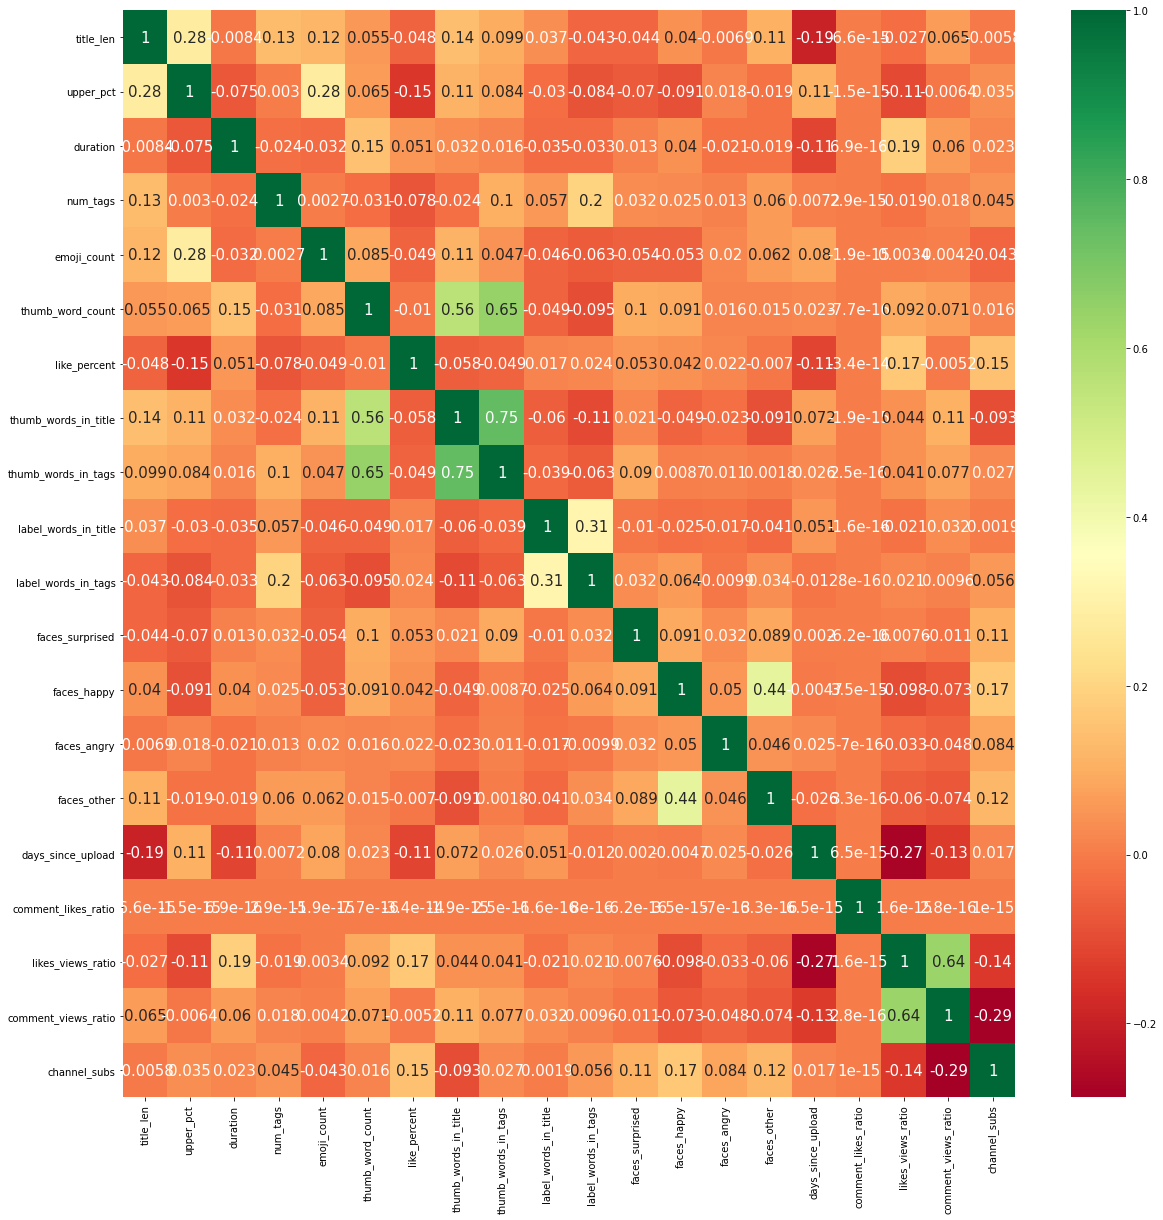

In [19]:
#List of numeric explanatory variables
num_x_vars=['title_len', 'upper_pct', 'duration', 'num_tags',
       'emoji_count', 'thumb_word_count', 'like_percent',
       'thumb_words_in_title', 'thumb_words_in_tags', 'label_words_in_title',
       'label_words_in_tags','faces_surprised','faces_happy','faces_angry','faces_other',
       'days_since_upload', 'comment_likes_ratio','likes_views_ratio','comment_views_ratio','channel_subs']

#, , 'channel_videos','comment_views_ratio', 'views_favorite_ratio', 'like_percent','views_like_ratio',
num_features=df_model[num_x_vars]

for var in num_x_vars:
    num_features[var] = num_features[var].astype(float)
    
print(num_features.describe())

plt.figure(figsize=(20,20))
sns.heatmap(num_features.corr(),annot=True,cmap="RdYlGn",annot_kws={"size":15})

### 4.3. Create a pipeline

*Pipelines* are a great way to keep the data modeling and preprocessing more organized and easier to understand. Creating a pipeline, we'll handle the missing values and the preprocessing covered in the previous two steps. 

As defined above, numerical missing entries will be filled with the mean value while missing categorical variables will be filled with "NA". Furthermore, categorical columns will also be preprocessed with One-Hot Encoding.

We are using *SimpleImputer* to fill in missing values and *ColumnTransformer* will help us to apply the numerical and categorical preprocessors in a single transformer.

In [13]:
# Preprocessing numerical values
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing categorical values
categorical_transformer = Pipeline(steps=[
                                   ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
                                   ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                   ])

# Pack the preprocessors together
preprocessor = ColumnTransformer(transformers=[
                                 ('num', numerical_transformer, numeric_cols),
                                 ('cat', categorical_transformer, categorical_cols)
                                 ])

## 5. Define a model

Now that we have bundled our preprocessors in a pipeline, we can define a model. In this article, we are working with **XGBoost**, one of the most effective machine learning algorithms, that presents great results in many Kaggle competitions. As a metric of evaluation, we are using the **Mean Absolute Error**.

In [14]:
# Define the model with default parameters
model = XGBRegressor(verbosity=0, random_state=0)

# Pack preprocessing and modeling together in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                              ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 16706.181988441782


## 3. Training and validation data

It is crucial to break our data into a set for training the model and another one to validate the results. It's worth mentioning that we should never use the test data here. Our test set stays untouched until we are satisfied with our model's performance.

What we're going to do is taking the predictors **X** and target vector **y** and breaking them into training and validation sets. For that, we'll use scikit-learn's `train_test_split`.

print(f'Shape of X_train_full: {X_train_full.shape}')
print(f'Shape of X_valid_full: {X_valid_full.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_valid: {y_valid.shape}')

## 6. Cross-validation

Using [Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html#) can yield better results. Instead of simply using the training and test sets, cross-validation will run our model on different subsets of the data to get multiple measures of model quality.

We'll use the cross-validator [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) in its default setup to split the training data into 5 folds. Then, each fold will be used once as validation while the remaining folds will form the training set. After that, [cross-validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) will evaluate the metrics. In this case, we're using the Mean Absolute Error. 

In [15]:
# Using KFold cross-validator
kfold = KFold(shuffle=True, random_state=0)

# Evaluating the Mean Absolute Error
scores = cross_validate(my_pipeline, X_train, y_train, 
                              scoring='neg_mean_absolute_error', cv=kfold)

# Multiply by -1 since sklearn calculates negative MAE
print('Average MAE score:', (scores['test_score'] * -1).mean())

Average MAE score: 16168.894833206665


With cross-validation we could improve our score, reducing the error. In the next step, we'll try to further improve the model, optimizing some hyperparameters.

## 7. Hyperparameter tuning

**XGBoost** in its default setup usually yields great results, but it also has plenty of hyperparameters that can be optimized to improve the model. Here, we'll use a method called [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) which will search over specified parameter values and return the best ones. Once again, we'll utilize the pipeline and the cross-validator *KFold* defined above.

*GridSearchCV* will perform an exhaustive search over parameters, which can demand a lot of computational power and take a lot of time to be finished. We can speed up the process a little bit by setting the parameter `n_jobs` to `-1`, which means that the machine will use all processors on the task.

In [16]:
"""
To pass parameter in a pipeline, we should add the names of the steps and the parameter name separated by a ‘__’.
Ex: Instead of 'n_estimators', we should set 'model__n_estimators'.
https://github.com/scikit-learn/scikit-learn/issues/18472
"""
# parameters to be searched over
param_grid = {'model__n_estimators': [10, 50, 100, 200, 400, 600],
              'model__max_depth': [2, 3, 5, 7, 10],
              'model__min_child_weight': [0.0001, 0.001, 0.01],
              'model__learning_rate': [0.01, 0.1, 0.5, 1]}

# find the best parameter
kfold = KFold(shuffle=True, random_state=0)
grid_search = GridSearchCV(my_pipeline, param_grid, scoring='neg_mean_absolute_error', cv=kfold, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

In [17]:
print('Best result:', round((grid_result.best_score_ * -1), 2), 'for', grid_result.best_params_)

Best result: 15750.17 for {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 0.0001, 'model__n_estimators': 400}


## 8. Generate test predictions

After tuning some hyperparameters, it's time to go over the modeling process again to make predictions on the test set. We'll define our final model based on the optimized values provided by *GridSearchCV*.

In [32]:
# Define final model
final_model = XGBRegressor(n_estimators=400, 
                           max_depth=3, 
                           min_child_weight=0.0001, 
                           learning_rate=0.1, 
                           verbosity=0, 
                           random_state=0
                           )

# Create a pipeline
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('final_model', final_model)
                                 ])

# Fit the model
final_pipeline.fit(X_train, y_train)

# Get predictions on the test set
final_prediction = final_pipeline.predict(X_test)

## 9. Submit your results

We're almost there! The machine learning modeling is done, but we still need to submit our results to have our score recorded.

This step is quite simple. We need to create a `.csv` file containing the predictions. This file consists of a DataFrame with two columns. In this case, one column for "Id" and the other one for the test predictions on the target feature. 


In [45]:
# Save test predictions to .csv file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': final_prediction})
output.to_csv('submission.csv', index=False)

## 10. Join the competition

Finally, we just need to join the competition. Please follow the steps below, according to Kaggle's instructions. 

*   Start by accessing the [competition page](https://www.kaggle.com/c/home-data-for-ml-course) and clicking on **Join Competition**.
*   In your Kaggle notebook, click on the blue Save Version button in the top right corner of the window.
*   A pop-up window will show up. Select the option **Save and Run All** and then click on the blue Save button.
*   A new pop-up shows up in the bottom left corner while your notebook is running. When it stops running, click on the number to the right of the **Save Version** button. You should click on the **ellipsis (...)** to the right of the most recent notebook version, and select **Open in Viewer**. This brings you into view mode of the same page.
*   Now, click on the **Output** tab on the right of the screen. Then, click on the blue **Submit** button to submit your results to the leaderboard.

After submitting, you can check your score and position on the [leaderboard](https://www.kaggle.com/c/home-data-for-ml-course/leaderboard).

![kaggle_img004](https://github.com/rmpbastos/data_science/blob/master/img/kaggle_img4.jpg?raw=true)






## Conclusion

This article was intended to be instructive, helping data science beginners to structure their first projects on Kaggle in simple steps. With this straightforward approach, I've got a score of **14,778.87**, which ranked this project in the Top 7%.

After further studying, you can go back on past projects and try to enhance their performance, using new skills you've learned. To improve this project, we could investigate and treat the outliers more closely, apply a different approach to missing values, or do some feature engineering, for instance.

My advice to beginners is to keep it simple when starting out. Instead of aiming at the "perfect" model, focus on completing the project, applying your skills correctly, and learning from your mistakes, understanding where and why you messed things up. The data science community is on constant expansion and there's plenty of more experienced folks willing to help on websites like Kaggle or Stack Overflow. Try to learn from their past mistakes as well! With practice and discipline, it's just a matter of time to start building more elaborate projects and climb up the ranking of Kaggle's competitions.